Importing Libraries

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models
import pathlib
import os
import cv2
import string
from keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preparation of dataset images:

In [2]:
class readDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape
    def imagesPath(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath,
                                                folder)).glob('*{}.*'.format(name)))
        return images
    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels = channels)
            image = tf.image.resize(image, self.imageShape)
            image/= 255
            listImages.append(image)
        return listImages
    def allDataset(self, label):
        images = self.readImages(self.imagesPath(label, name = ')'), channels = 3)
        masks = np.array(self.readImages(self.imagesPath(label, name = 'mask'), channels = 1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks
    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([np.ones(shape = (len(images_benign),))*0,
                           np.ones(shape = (len(images_malignant), ))*1,
                           np.ones(shape = (len(images_normal), ))*2])
        return images, masks, labels

    def dataAugmentation(self, images, masks, labels):
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        for image, mask, label in zip(images, labels, masks):
            image1 = tf.image.adjust_contrast(image, contrast_factor = 2)
            image2 = tf.image.adjust_brightness(image, delta = 0.3)
            imagesupdate.append(image), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image1), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image2), masksupdate.append(mask), labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)

Loading & Reading the Dataset

In [3]:
datasetpath = 'drive/My Drive/Major Project/Dataset_BUSI_with_GT'
datasetObject = readDataset(datasetpath, [128, 128])
images, masks, labels = datasetObject.finalDataset(['benign', 'malignant', 'normal'])

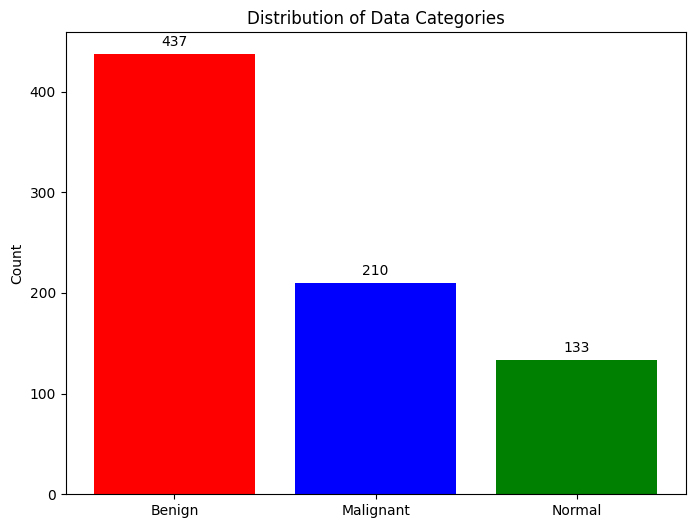

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter(labels)

categories = list(label_counts.keys())
category_counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, category_counts, color=['red', 'blue', 'green'])
plt.ylabel('Count')
plt.title('Distribution of Data Categories')

for bar, count in zip(bars, category_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', va='bottom')

# Set X-axis labels
plt.xticks(categories, ['Benign', 'Malignant', 'Normal'])

plt.show()

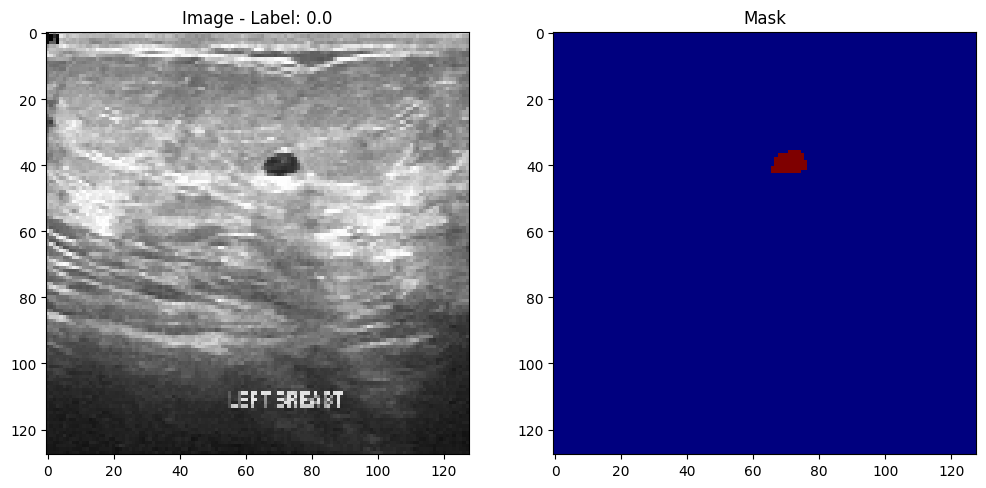

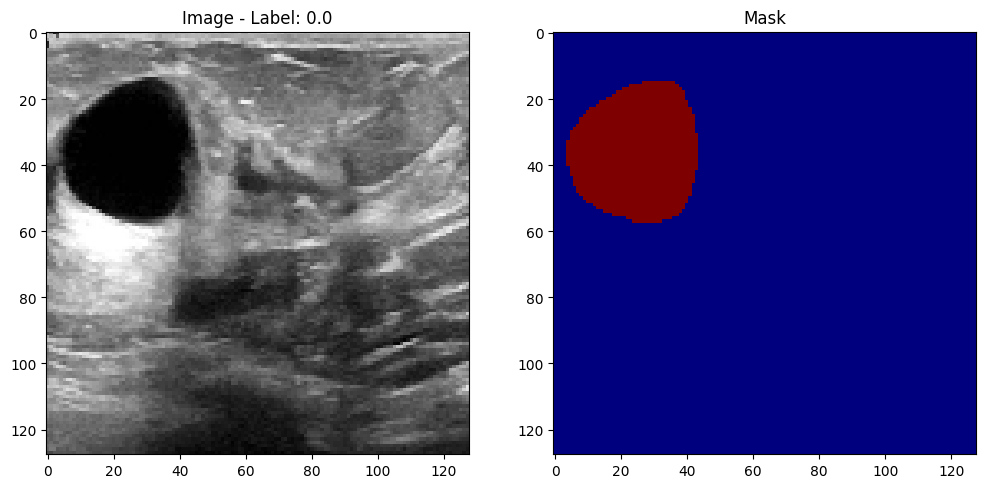

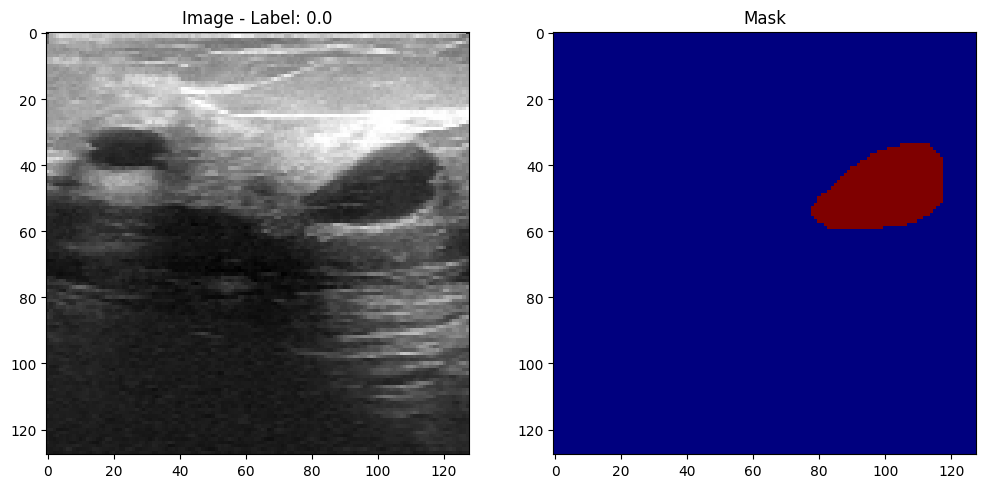

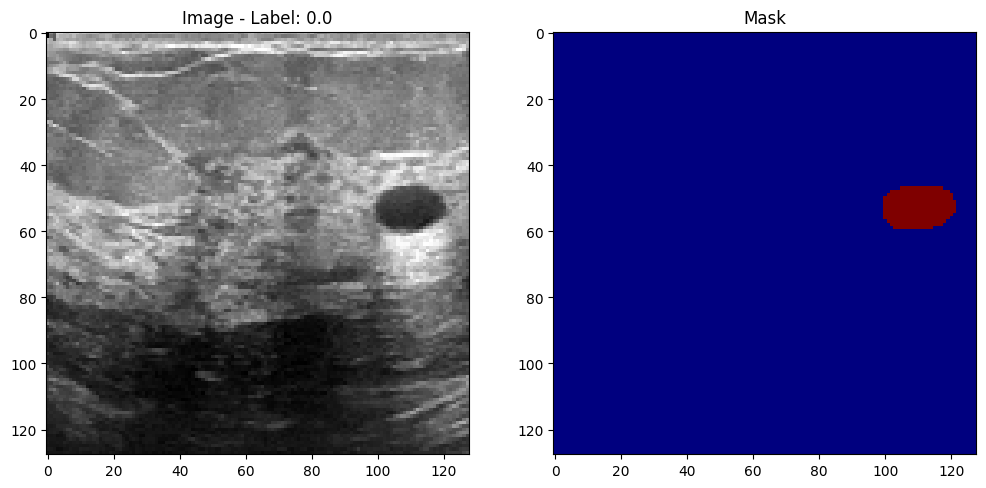

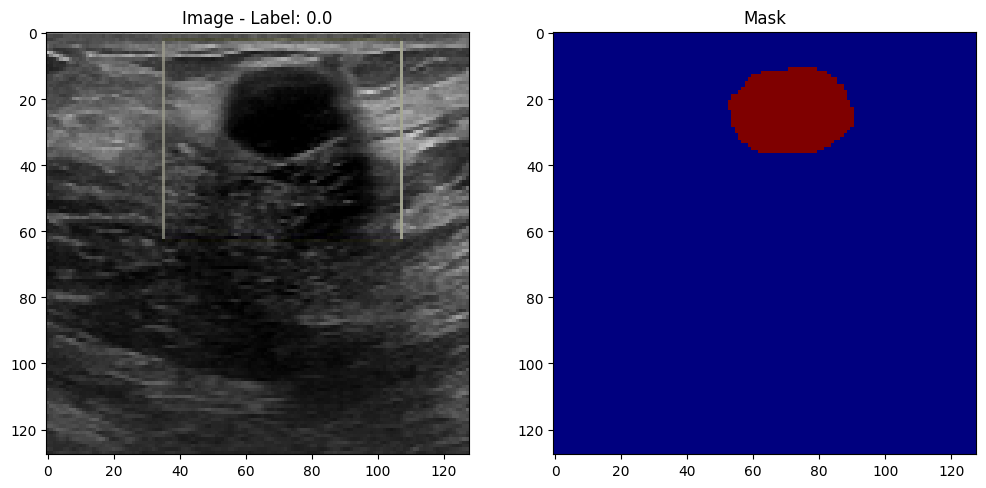

In [5]:
num_samples_to_plot = 5
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 6))

    # ultrasound
    plt.subplot(1, 2, 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Image - Label: {labels[i]}')

    # mask
    if masks is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i], cmap='jet')
        plt.title('Mask')

    plt.show()

Data Augmentation Process

In [6]:
images, masks, labels = datasetObject.dataAugmentation(images, labels, masks)
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

Unique Values of benign, malignant and normal classes

In [7]:
np.unique(labels, return_counts = True)

(array([0., 1., 2.]), array([1311,  630,  399]))

In [8]:
def showImagesWithMask(images, masks, labels):
    plt.figure(figsize = (12, 12))
    for i in range(len(images)):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha = 0.3, cmap = 'jet')
        plt.title(labels[i])
    plt.legend()

Dividing the dataset into training and test images.

In [10]:
randomIndexs = np.random.randint(0, len(images), size = (len(images), ))
images = images[randomIndexs]
masks = masks[randomIndexs]
labels = labels[randomIndexs]
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [11]:
valid = 500
trainDataset = [images[:images.shape[0] - valid],
         masks[:images.shape[0] - valid],
         labels[:images.shape[0] - valid]]
validDataset = [images[images.shape[0] - valid:],
         masks[images.shape[0] - valid:],
         labels[images.shape[0] - valid:]]

Shape of Training dataset

In [12]:
trainDataset[0].shape, trainDataset[1].shape, trainDataset[2].shape

((1840, 128, 128, 3), (1840, 128, 128, 1), (1840,))

Shape of Testing/Valid dataset

In [13]:
validDataset[0].shape, validDataset[1].shape, validDataset[2].shape

((500, 128, 128, 3), (500, 128, 128, 1), (500,))

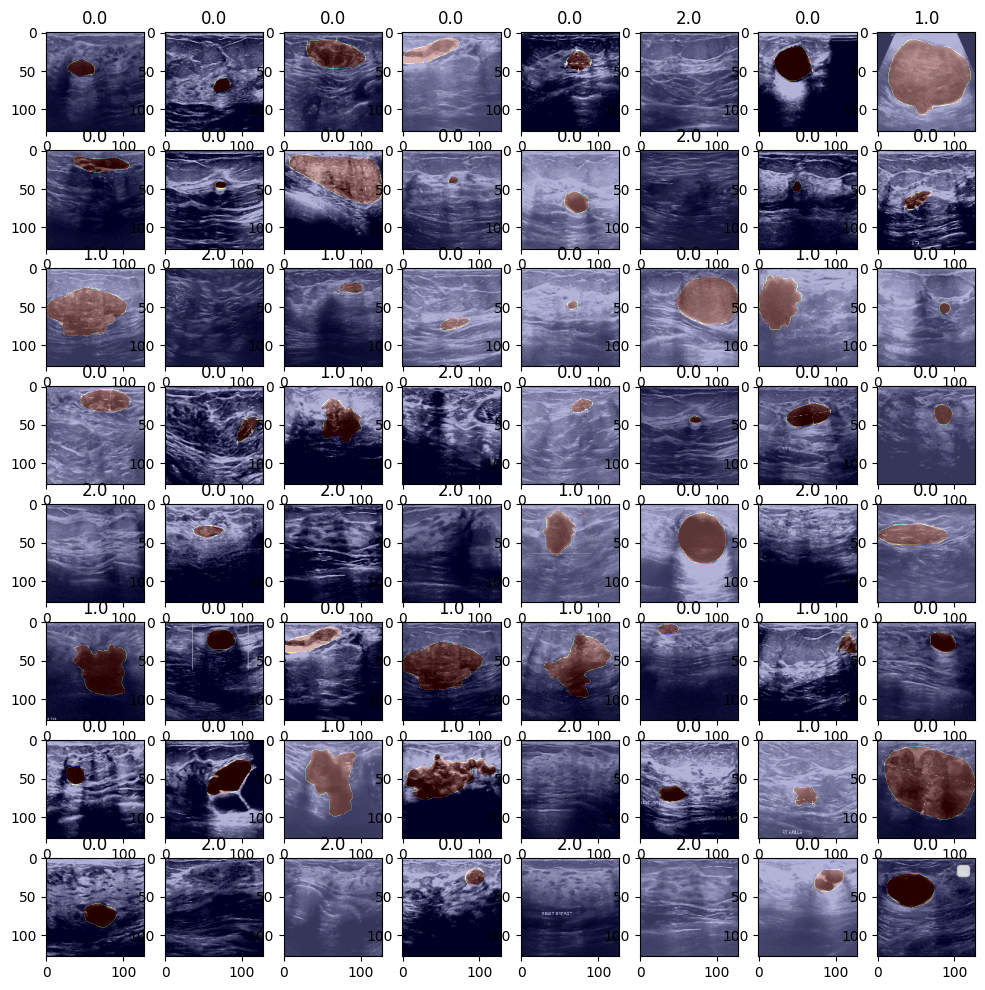

In [14]:
showImagesWithMask(trainDataset[0][:64], trainDataset[1][:64], trainDataset[2][:64])

Neural network architecture proposal:

In [15]:
def convolution(inputs, padding, strides, filter, kernel_size):
    x = inputs
    y = layers.Conv2D(filter, kernel_size = 1, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(y)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, y])
    x = layers.Activation('relu')(x)
    return x

Filtering & Average Pooling

In [16]:
def encoder(inputs, filter):
    correlation = convolution(inputs, padding = 'same', strides = 1, filter = filter,
                             kernel_size = 5)
    downsample = layers.AveragePooling2D()(correlation)
    return correlation, downsample

Upsampling Activation & Batch Normalization Layer

In [17]:
def decoder(inputs, skip_connection, filter):
    upsample = layers.Conv2DTranspose(filter, 5, padding = 'same', strides = 2,
                                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(inputs)
    upsample = layers.Activation('relu')(upsample)
    upsample = layers.BatchNormalization()(upsample)
    connection = layers.average([upsample, skip_connection])
    correlation = convolution(connection, padding = 'same', strides = 1, filter = filter,
                             kernel_size = 5)
    return correlation

Downsampling of images and finding no. of parameters

In [18]:
input = layers.Input(shape = (128, 128, 3))
filter = 32
corr1, downsample1 = encoder(input, filter)
corr2, downsample2 = encoder(downsample1, filter*2)
corr3, downsample3 = encoder(downsample2, filter*4)
corr4, downsample4 = encoder(downsample3, filter*8)
downsample4 = convolution(downsample4, padding = 'same', strides = 1, filter = filter*8,
                         kernel_size = 5)
features_vector_1 = layers.GlobalAveragePooling2D()(downsample4)
features_vector_2 = layers.Flatten()(downsample4)
features_vector_2 = layers.Dropout(0.5)(features_vector_2)
features_vector_1 = layers.Dropout(0.5)(features_vector_1)
encoder_x = layers.Dense(64, name = 'latent_space',
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(features_vector_1)
x = layers.Dense(downsample4.shape[1]*downsample4.shape[2]*downsample4.shape[3],
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(encoder_x)
x = layers.Reshape((downsample4.shape[1], downsample4.shape[2], downsample4.shape[3]),
                  name = 'reshape')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
decoder_corr1 = decoder(x, corr4, filter*8)
decoder_corr2 = decoder(decoder_corr1, corr3, filter*4)
decoder_corr3 = decoder(decoder_corr2, corr2, filter*2)
decoder_corr4 = decoder(decoder_corr3, corr1, filter)
output = layers.Conv2DTranspose(1, 5, padding = 'same', strides = 1)(decoder_corr4)
output = layers.Activation('sigmoid', name = 'UNET')(output)
labelOutput = layers.Dense(32, activation = 'relu')(features_vector_2)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(16, activation = 'relu')(labelOutput)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(1, name = 'label')(labelOutput)
m = models.Model(inputs = input, outputs = [output, labelOutput])
m.compile(loss = [tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
          optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
          metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')],
          )
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         128       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         25632     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [20]:
history = m.fit(trainDataset[0], [trainDataset[1], trainDataset[2]], epochs = 2,
               validation_data = (validDataset[0], [validDataset[1], validDataset[2]]),
               batch_size = 8, callbacks = [
                   tf.keras.callbacks.EarlyStopping(patience = 12, monitor = 'val_loss',
                                                   mode = 'min', restore_best_weights = True)
               ])

Epoch 1/2
230/230 [==============================] - 69s 160ms/step - loss: 5.8166 - UNET_loss: 0.1040 - label_loss: 1.5342 - UNET_accuracy: 0.8630 - UNET_precision: 0.1210 - UNET_recall: 0.1157 - label_accuracy: 0.4908 - label_precision: 0.4841 - label_recall: 0.4228 - val_loss: 4.7877 - val_UNET_loss: 0.0795 - val_label_loss: 0.6181 - val_UNET_accuracy: 0.9224 - val_UNET_precision: 0.0023 - val_UNET_recall: 1.2657e-05 - val_label_accuracy: 0.5080 - val_label_precision: 0.3521 - val_label_recall: 0.1163
Epoch 2/2
230/230 [==============================] - 34s 148ms/step - loss: 5.5499 - UNET_loss: 0.0601 - label_loss: 1.4847 - UNET_accuracy: 0.9232 - UNET_precision: 0.5312 - UNET_recall: 0.2766 - label_accuracy: 0.4728 - label_precision: 0.4599 - label_recall: 0.4063 - val_loss: 4.7315 - val_UNET_loss: 0.0573 - val_label_loss: 0.7479 - val_UNET_accuracy: 0.9240 - val_UNET_precision: 0.5115 - val_UNET_recall: 0.3465 - val_label_accuracy: 0.5320 - val_label_precision: 0.4588 - val_label

Results and metrics:


In [21]:
m.evaluate(trainDataset[0], [trainDataset[1], trainDataset[2]])

58/58 [==============================] - 9s 123ms/step - loss: 4.7471 - UNET_loss: 0.0555 - label_loss: 0.7653 - UNET_accuracy: 0.9279 - UNET_precision: 0.5691 - UNET_recall: 0.3797 - label_accuracy: 0.5212 - label_precision: 0.4914 - label_recall: 0.2165


[4.7470903396606445,
 0.05549090728163719,
 0.765259325504303,
 0.927910566329956,
 0.5691449642181396,
 0.379725843667984,
 0.521195650100708,
 0.4913793206214905,
 0.21645569801330566]

In [22]:
m.evaluate(validDataset[0], [validDataset[1], validDataset[2]])

16/16 [==============================] - 3s 209ms/step - loss: 4.7315 - UNET_loss: 0.0573 - label_loss: 0.7479 - UNET_accuracy: 0.9240 - UNET_precision: 0.5115 - UNET_recall: 0.3465 - label_accuracy: 0.5320 - label_precision: 0.4588 - label_recall: 0.1814


[4.731468200683594,
 0.05726929381489754,
 0.7478587627410889,
 0.9240447878837585,
 0.511470377445221,
 0.3465021550655365,
 0.5320000052452087,
 0.4588235318660736,
 0.18139535188674927]

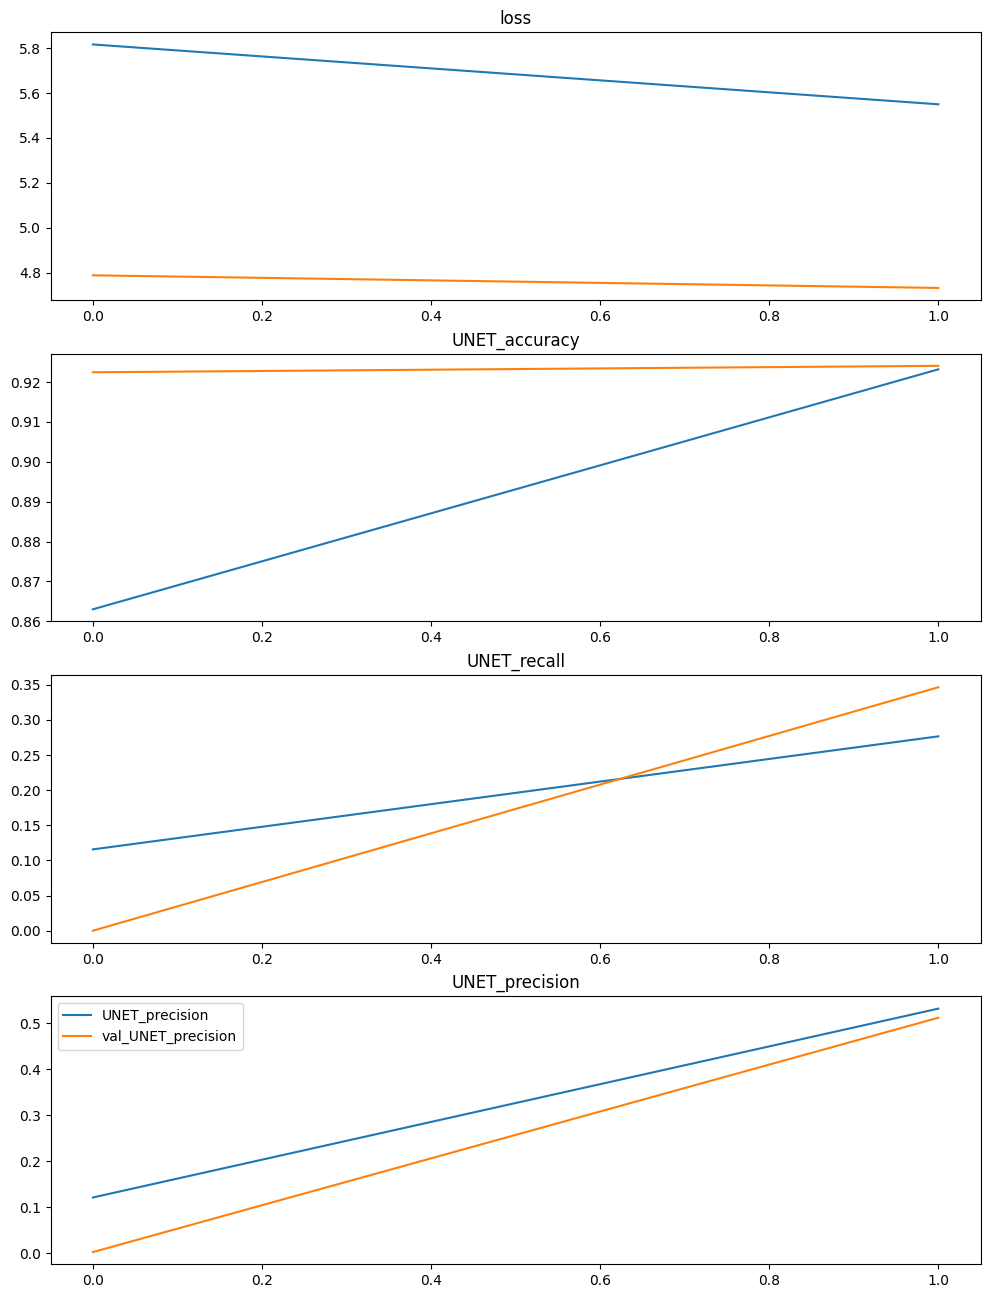

In [23]:
metrics = ['loss', 'UNET_accuracy', 'UNET_recall', 'UNET_precision']
plt.figure(figsize = (12, 16))
for i in range(4):
    plt.subplot(4, 1, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()

In [24]:
masks_pred, _ = m.predict(validDataset[0])

16/16 [==============================] - 2s 98ms/step


In [25]:
masks_pred.shape, validDataset[1].shape

((500, 128, 128, 1), (500, 128, 128, 1))

In [26]:
masks_pred = (masks_pred >= 0.5).astype('int32')
np.unique(masks_pred), np.unique(validDataset[1])

(array([0, 1], dtype=int32), array([0, 1], dtype=int32))

In [27]:
masks_pred = layers.Flatten()(masks_pred)
masks_pred  = np.reshape(masks_pred, -1)
masks_actual = layers.Flatten()(validDataset[1])
masks_actual  = np.reshape(masks_actual, -1)
masks_pred.shape, masks_actual.shape

((8192000,), (8192000,))

Performance Metrics

In [28]:
print(classification_report(masks_actual, masks_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96   7559952
           1       0.51      0.35      0.41    632048

    accuracy                           0.92   8192000
   macro avg       0.73      0.66      0.69   8192000
weighted avg       0.91      0.92      0.92   8192000



In [29]:
tn, fp, fn, tp = confusion_matrix(masks_actual, masks_pred).ravel()

In [30]:
metrics = pd.DataFrame([accuracy_score(masks_actual, masks_pred)*100,
                        precision_score(masks_actual, masks_pred)*100,
                        recall_score(masks_actual, masks_pred)*100,
                        f1_score(masks_actual, masks_pred)*100,
                        (tn / (tn+fp))*100,
                        (2*tp/(2*tp + fp + fn))*100,
                        (tp/(tp + fn))*100],
                       index = ['Accuracy Score', 'Precision Score',
                                'Recall Score', 'F1 Score', 'specificity',
                                'dice Score', 'sensitivity'],
                       columns = ['Metrics For Validation Data'])
metrics.head(n= 8)

Metrics For Validation Data
Accuracy Score                     92.404565
Precision Score                    51.147903
Recall Score                       34.649425
F1 Score                           41.312369
specificity                        97.233170
dice Score                         41.312369
sensitivity                        34.649425

In [31]:
def segmentation(data):
    masks_pred, _ = m.predict(data)
    masks_pred = np.array(masks_pred)
    masks_pred = (masks_pred >= 0.5).astype('int32')
    return masks_pred

In [32]:
valid_masks = segmentation(validDataset[0])
valid_masks.shape

16/16 [==============================] - 1s 96ms/step


(500, 128, 128, 1)

Visual review of the results:


In [33]:
def draw(images, masks, y_pred):
  plt.figure(figsize = (12, 25))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(60):
    plt.subplot(10, 6, (i + 1))
    if index == -1:
      plt.imshow(images[n])
      plt.title('Image')
      index = 0
    elif index == 0:
      plt.imshow(images[n])
      plt.imshow(masks[n], alpha = 0.3, cmap = 'jet')
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(images[n])
      plt.imshow(np.reshape(y_pred[n], (128, 128)), alpha = 0.3, cmap = 'jet')
      plt.title('Predict Mask')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

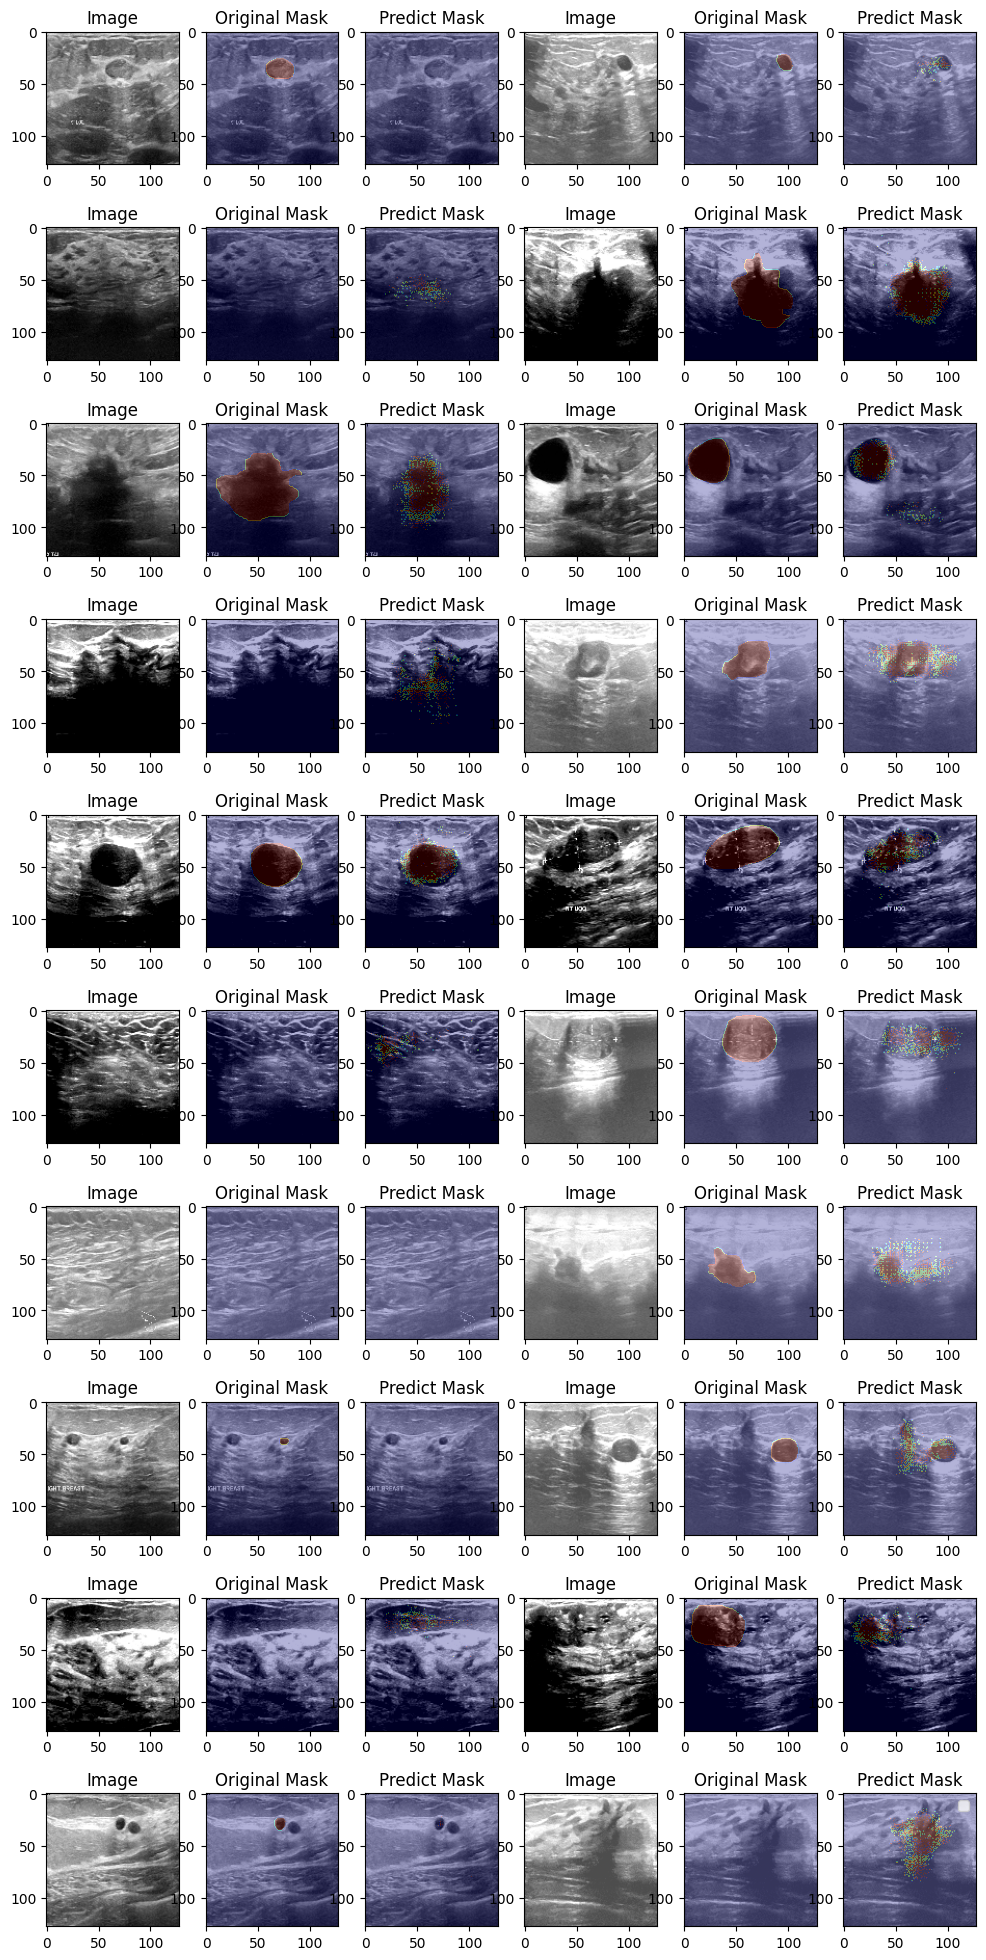

In [34]:
draw(validDataset[0], validDataset[1], valid_masks)

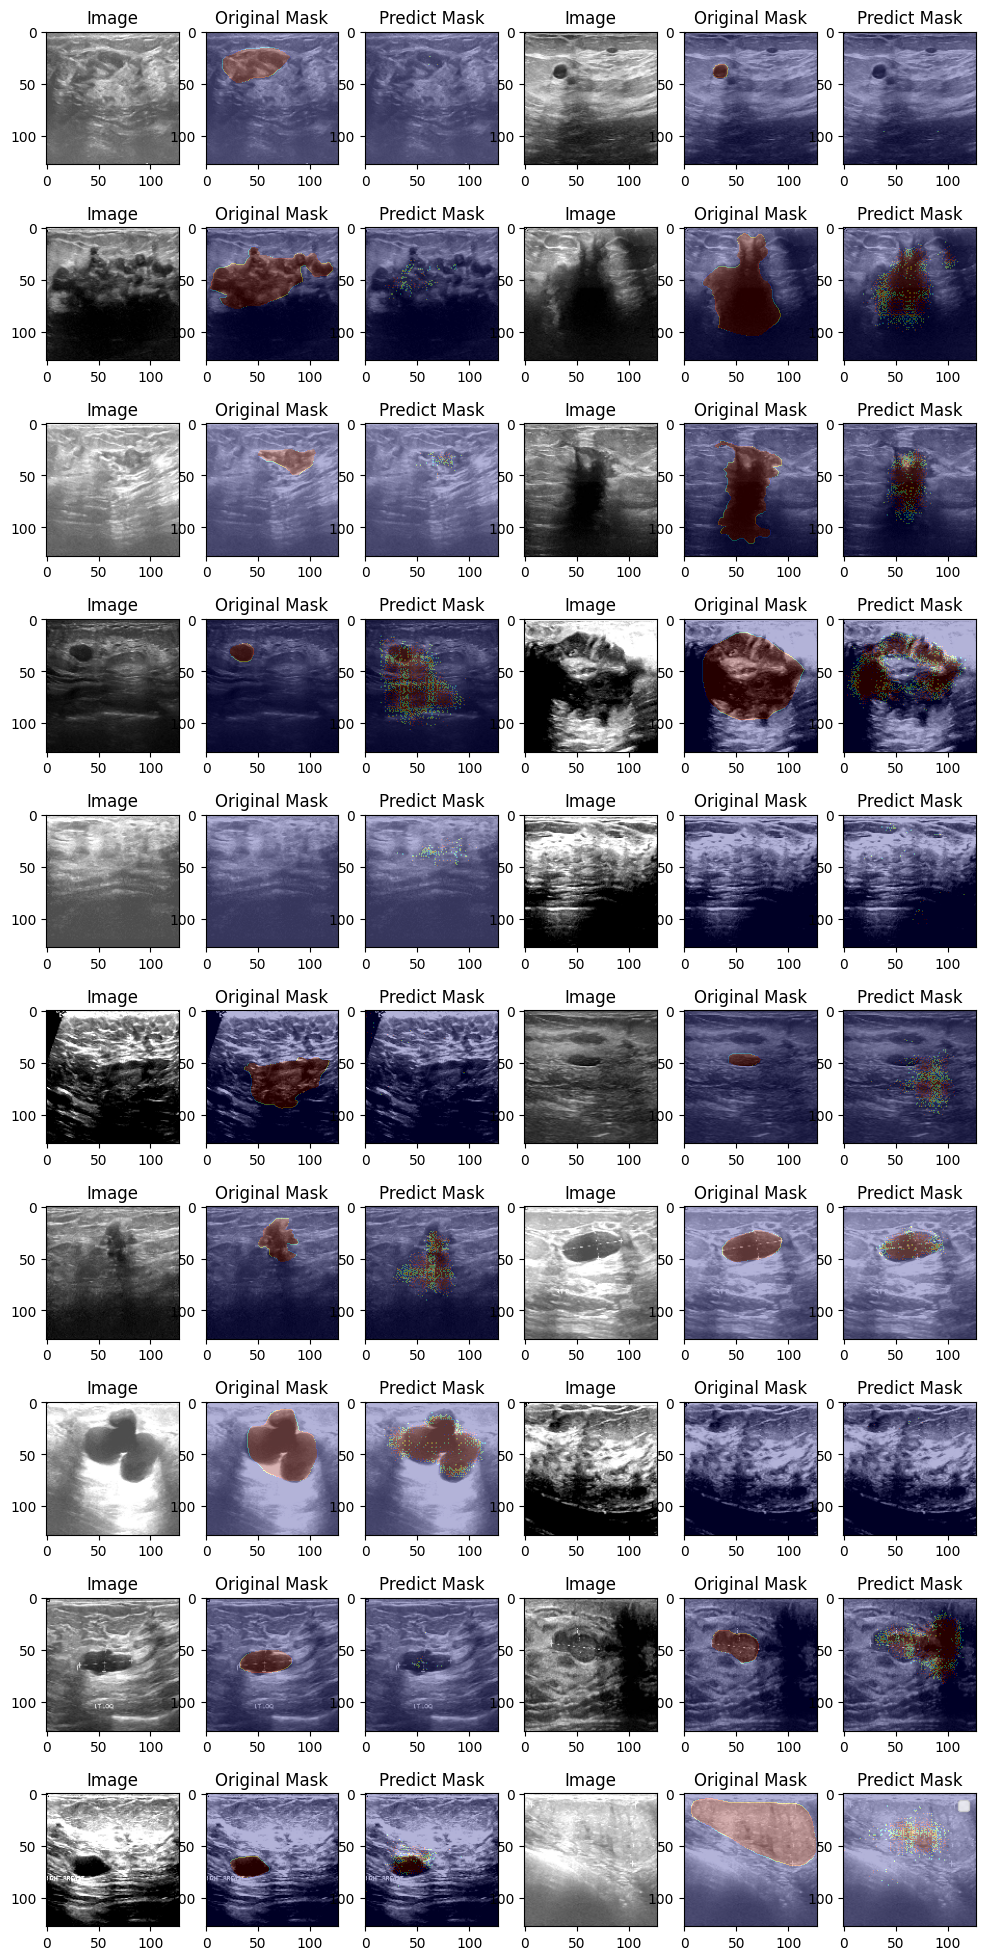

In [36]:
draw(validDataset[0], validDataset[1], valid_masks)

In [37]:
train_masks = segmentation(trainDataset[0])
train_masks.shape

58/58 [==============================] - 6s 96ms/step


(1840, 128, 128, 1)

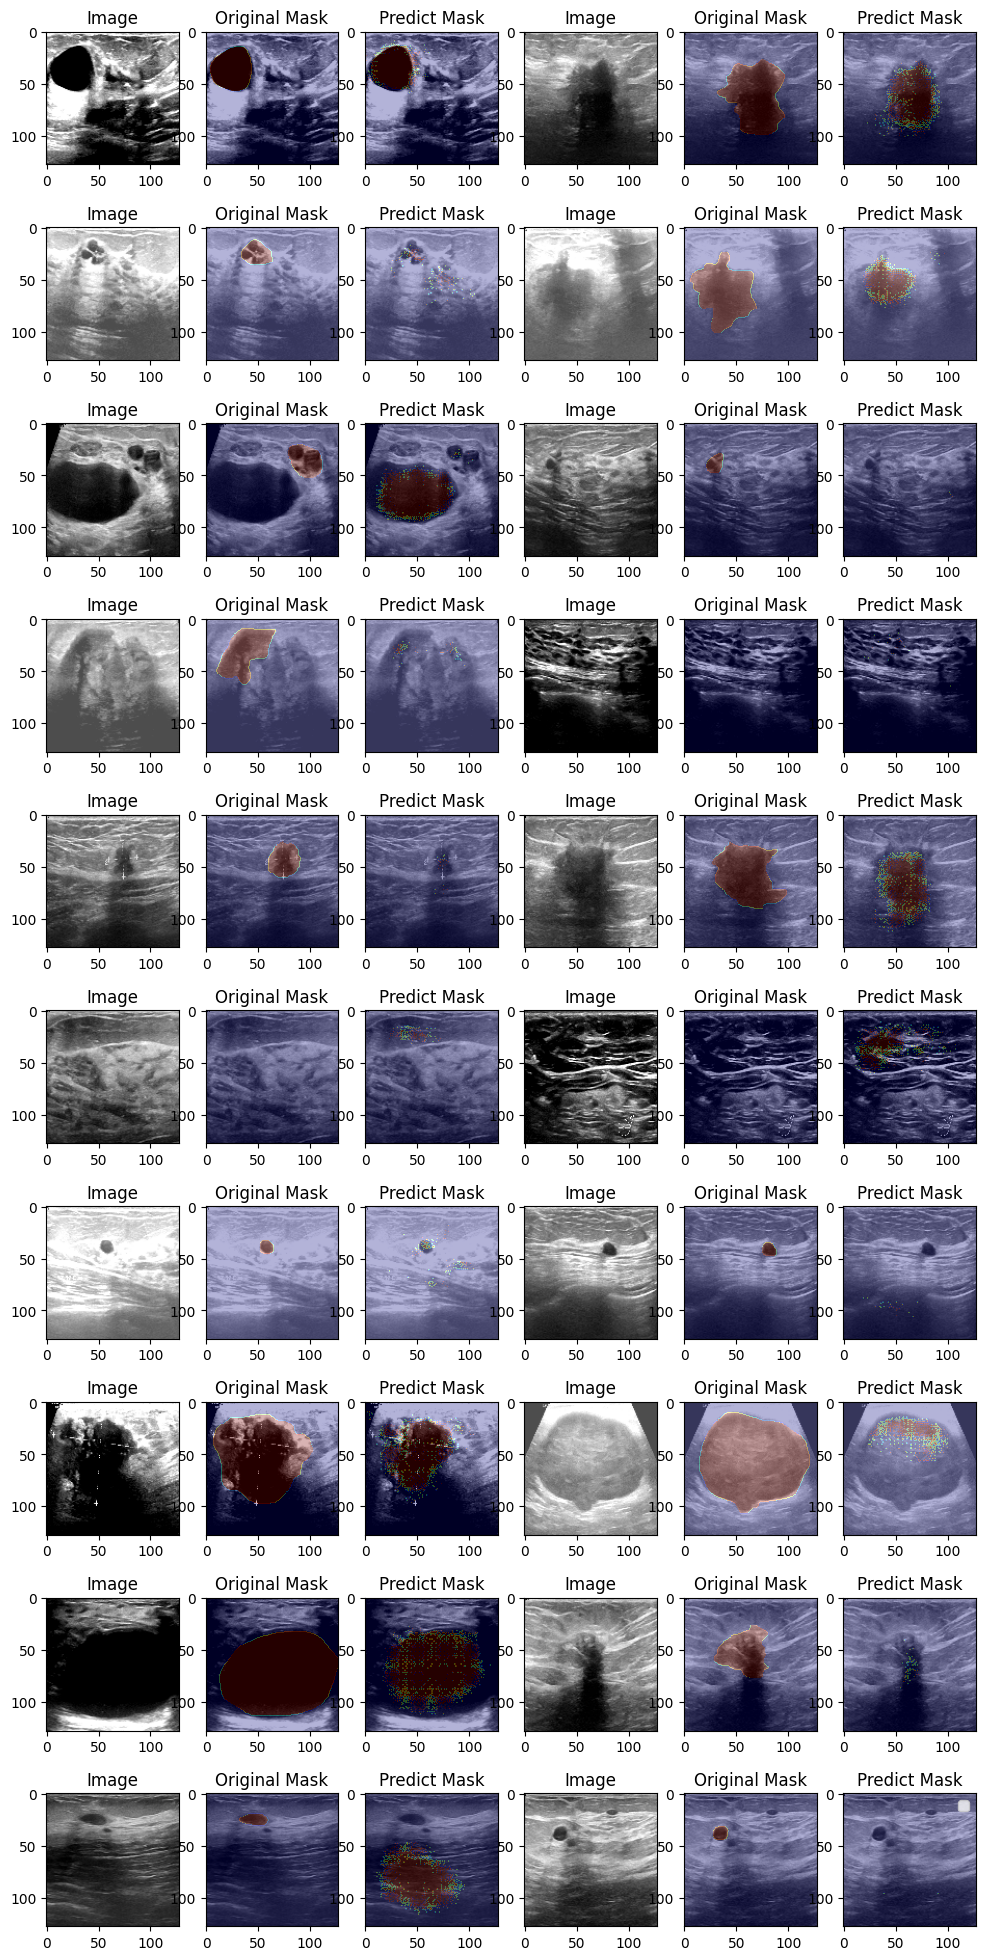

In [39]:
draw(trainDataset[0], trainDataset[1], train_masks)

In [40]:
os.listdir("drive/My Drive/Major Project/Dataset_BUSI_with_GT")

['normal', 'benign', 'malignant']

In [41]:
def import_images(folder,target):
    images = []
    for item in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,item),0)
        if img is not None:
            images.append([img,target])
    return images

In [42]:
bengin = import_images("drive/My Drive/Major Project/Dataset_BUSI_with_GT/benign/",0)
malignant = import_images("drive/My Drive/Major Project/Dataset_BUSI_with_GT/malignant/",1)
normal = import_images("drive/My Drive/Major Project/Dataset_BUSI_with_GT/normal/",2)

In [43]:
bengin.extend(malignant)
bengin.extend(normal)

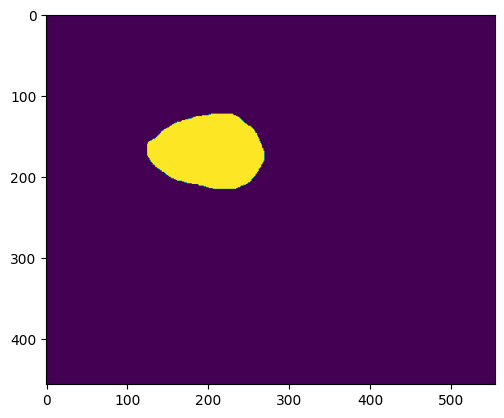

In [44]:
plt.imshow(bengin[600][0])

In [45]:
full_data = bengin

In [46]:
feature_matrix = []
label = []
for x,y in full_data:
    feature_matrix.append(x)
    label.append(y)

In [47]:
feature_matrix[0]

array([[  7,   2,   4, ..., 197, 184, 176],
       [198,  45,   0, ..., 200, 191, 183],
       [212,  45,   9, ..., 207, 203, 194],
       ...,
       [ 25,  24,  23, ...,  22,  27,  26],
       [ 24,  23,  23, ...,  30,  32,  31],
       [ 26,  25,  25, ...,  34,  34,  32]], dtype=uint8)

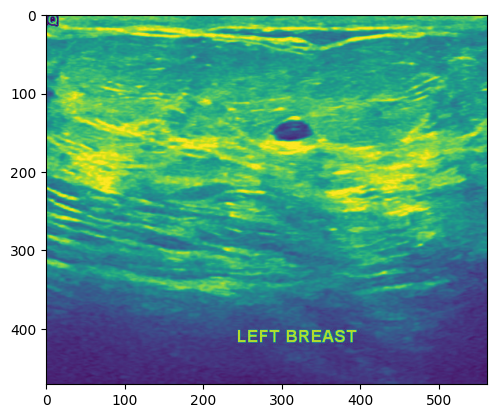

In [48]:
plt.imshow(feature_matrix[0])

In [49]:
label[1500]

2

In [50]:
## resized image
X=[]
img_size=128

for x in feature_matrix:
    new_array = cv2.resize(x,(img_size,img_size))
    X.append(new_array)

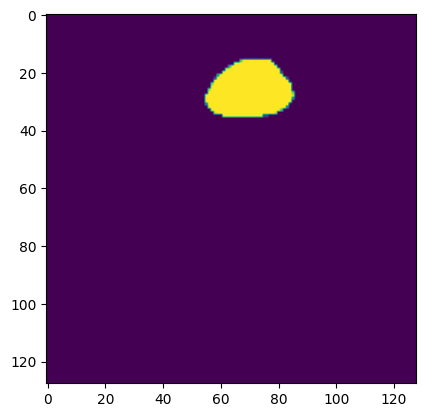

In [51]:
plt.imshow(X[222])

In [52]:
X_corrected = []
for image in X:
    image = image/255
    X_corrected.append(image)

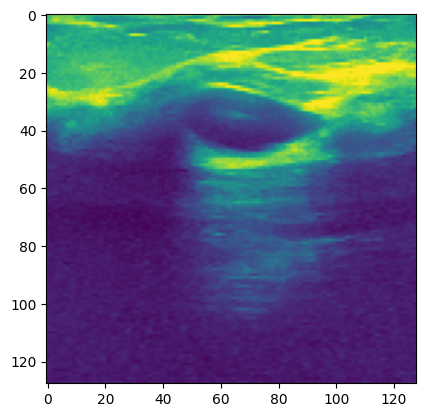

In [53]:
plt.imshow(X_corrected[213])

In [54]:
import numpy as np
np.array(X_corrected).shape

(1578, 128, 128)

In [55]:
X_M = np.array(X_corrected)

In [56]:
X_M.shape[1]

128

In [57]:
print(np.array(X_corrected).shape)
print(np.array(X_corrected).shape[0])
print(np.array(X_corrected).shape[1])
print(np.array(X_corrected).shape[2])

(1578, 128, 128)
1578
128
128


In [58]:
X_M.shape

(1578, 128, 128)

In [59]:
X_M_R =X_M.reshape(X_M.shape[0],X_M.shape[1],X_M.shape[2],1)

In [60]:
X_M_R.shape

(1578, 128, 128, 1)

In [61]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_M_R,label)

In [62]:
X_train.shape

(1183, 128, 128, 1)

In [63]:
X_test.shape

(395, 128, 128, 1)

In [64]:
import sys
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import Adam

In [65]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128,1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    # compile model
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## sparse_categorical_crossentropy

In [66]:
model =  define_model()
history = model.fit(np.array(X_train),np.array(y_train), epochs=2,validation_data=(X_test, np.array(y_test)))

Epoch 1/2
37/37 [==============================] - 12s 122ms/step - loss: 0.9500 - accuracy: 0.5393 - val_loss: 0.8323 - val_accuracy: 0.6734
Epoch 2/2
37/37 [==============================] - 2s 60ms/step - loss: 0.7980 - accuracy: 0.6593 - val_loss: 0.7764 - val_accuracy: 0.6557


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


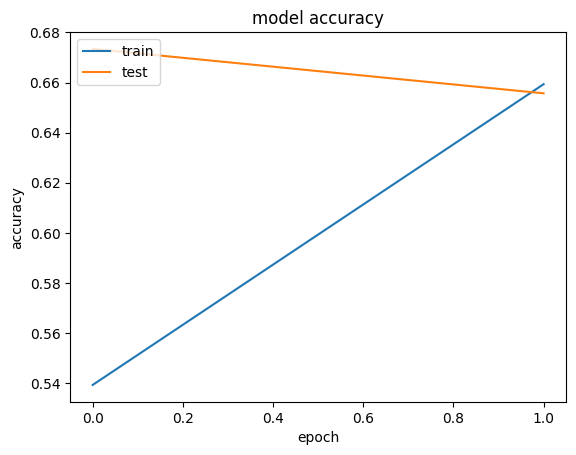

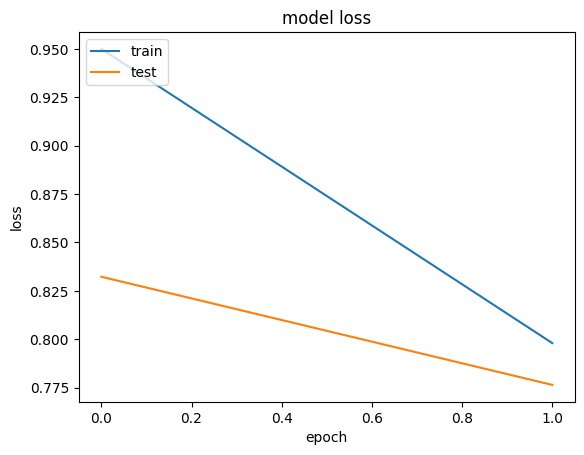

In [67]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
model.evaluate(np.array(X_test),np.array(y_test))

13/13 [==============================] - 0s 20ms/step - loss: 0.7764 - accuracy: 0.6557


[0.7764302492141724, 0.6556962132453918]

In [69]:
predicted = []
for item in model.predict(X_test):
    predicted.append(np.argmax(item))

13/13 [==============================] - 0s 18ms/step


In [70]:
X_test.shape

(395, 128, 128, 1)

In [71]:
#### lebel of the X_test prediction
for item in predicted:
    print(item,)

0
0
0
1
0
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
1
2
0
1
2
1
0
0
1
0
1
0
0
0
2
0
0
1
0
2
0
2
0
0
0
0
0
0
1
0
2
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
2
0
0
0
2
0
2
0
1
0
0
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
2
0
2
0
0
1
0
0
2
0
0
1
0
0
1
0
0
0
1
0
0
0
0
1
2
0
2
1
1
0
0
0
0
0
1
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
2
2
0
0
0
1
1
0
0
1
1
0
0
2
0
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
2
2
2
0
0
0
1
0
1
0
0
1
0
0
2
0
0
0
1
1
0
1
1
1
2
0
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
2
0
0
2
1
0
0
1
0
1
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
1
0
1
0
2
0
0
0
0
0
1
1
0
0
0
0
0
0
2
0
1
0
2
0
0
0
0
0
0
0
0
0


In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test,predicted)
conf

array([[193,  35,   0],
       [ 66,  36,   0],
       [ 35,   0,  30]])

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test,predicted)
conf

array([[193,  35,   0],
       [ 66,  36,   0],
       [ 35,   0,  30]])

Text(0.5, 155.72222222222217, 'Predicted')

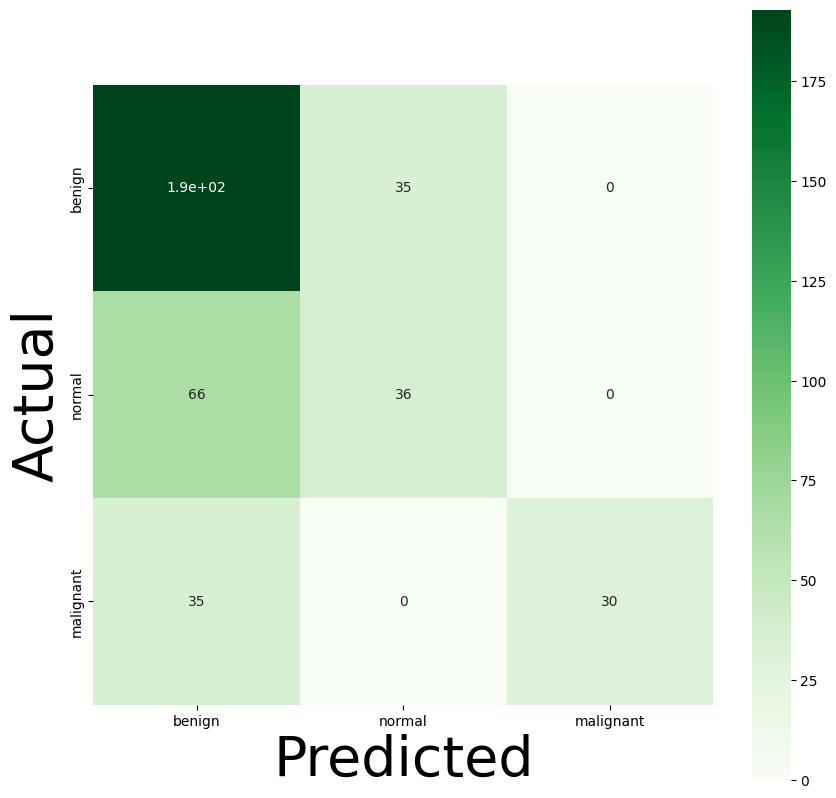

In [74]:
info = [
    'benign'   ,  # 0
    'normal'   ,  # 1
    'malignant',  # 2
]
plt.figure(figsize = (10,10))
ax = sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

<Axes: >

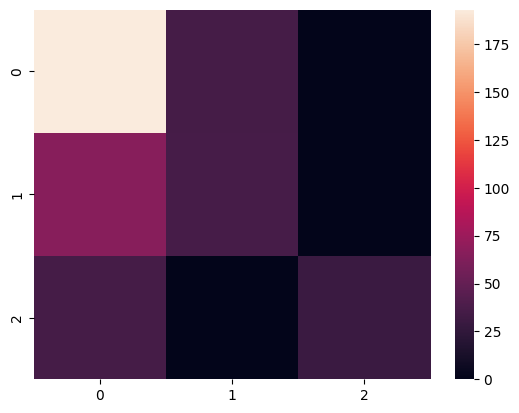

In [75]:
import seaborn as sns
sns.heatmap(conf)